In [1]:
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from imutils import paths
import os
import cv2
import datetime
import numpy as np

# Data Preprocess

In [2]:
# load train and test dataset
def load_dataset(base_dir):
	# load dataset
  print("\n[INFO] loading images...")
  imagePaths = list(paths.list_images(base_dir))

  labels = []
  images = []

  for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    if image is None:
      continue
    
    label = imagePath.split(os.path.sep)[-2]

    image = cv2.resize(image, image_shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    images.append(image)
    labels.append(label)
  
  images = np.array(images)
  labels = np.array(labels)

  trainX, testX, trainY, testY = train_test_split(images, labels, test_size=0.2)
  
  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], image_size, image_size, 3))
  testX = testX.reshape((testX.shape[0], image_size, image_size, 3))
  print('data training', str(trainX.shape[0]))
  print('data testing', str(testX.shape[0]))
  
  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# Model

In [3]:
# define cnn model with MobileNetV2
def define_model():
  base_model = MobileNetV2(input_shape=(image_size,image_size,3), 
                           include_top=False)
  # freeze the base layer
  for layer in base_model.layers:
    layer.trainable = False
  
  last_output = base_model.output
  x = GlobalAveragePooling2D()(last_output)
  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(5, activation='softmax')(x)

  model = Model(base_model.input, x)

  model.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
  return model

# Training

In [5]:
def train_model(checkpoint_path):
  # use checkpoint to save best model
  checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss',
                               save_best_only=True,
                               mode='auto', verbose=1)
  # define the model
  model = define_model()

  # training the head of the network
  print("[INFO] training head...")
  start = datetime.datetime.now()
  history = model.fit(trainX, trainY,
                      validation_data=(testX, testY),
                      epochs=10,
                      verbose=1,
                      callbacks=[checkpoint])
  end = datetime.datetime.now()
  elapsed = end - start
  # model.save(checkpoint_path)
  print ('Time:', elapsed)

  return model, history

def plot_training(history):
  # training plot
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epoch_range = range(len(acc))

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epoch_range, acc, label='Training Accuracy')
  plt.plot(epoch_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epoch_range, loss, label='Training Loss')
  plt.plot(epoch_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

# Testing

In [6]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, classification_report

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  #Add Normalization Option
  '''prints pretty confusion metric with normalization option'''
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  # print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label') 

def testing():
  # make predictions on the testing set
  print("[INFO] evaluating network...")
  (test_loss, test_accuracy) = model.evaluate( 
      testX, testY, verbose=1)
  print("[INFO] Test Accuracy: {:.2f}%".format(test_accuracy * 100)) 
  print("[INFO] Test Loss: {:.4f}".format(test_loss), end='\n\n') 


  # predict testing data
  predIdxs = model.predict(testX)
  predIdxs = np.argmax(predIdxs, axis=1)

  # convert y
  testY_categorical = [np.where(r==1)[0][0] for r in testY]
  classes = list(class_labels.values())
  # show a nicely formatted classification report
  print(classification_report(testY_categorical, predIdxs,
  target_names=classes))

  # compute the confusion matrix and and use it to derive the raw
  # accuracy, sensitivity, and specificity
  cm = confusion_matrix(testY_categorical, predIdxs)
  total = len(testY_categorical)

  # show the confusion matrix, accuracy, sensitivity, and specificity
  print(cm, end="\n\n")

  # show confusion matrix
  plot_confusion_matrix(cm, classes, normalize=True)

# Predict

In [7]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict(show=False):
  upload = files.upload()
  
  for fn in upload.keys():
    # predict image
    path = fn
    img = cv2.imread(path)
    img = cv2.resize(img, image_shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if show == True:
      plt.figure()
      plt.imshow(img) 
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    img_tensor = np.vstack([img_tensor])

    classes = model.predict(img_tensor)
    pred = np.argmax(classes, axis=1)

    for key, value in class_labels.items():
      if pred == key:
        print(value, np.max(classes))

# Main

In [10]:
class_labels = {0: 'batik priangan',
                1: 'batik megamendung',
                2: 'batik pring sedapur',
                3: 'batik kawung',
                4: 'batik parang'}

image_shape = (224, 224)
image_size = 224

# load dataset
trainX, trainY, testX, testY = load_dataset("# the dataset directory")
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)


[INFO] loading images...
data training 781
data testing 196


In [20]:
model, history = train_model("# directory to save model")

[INFO] training head...
Epoch 1/10
25/25 [==============================] - 4s 82ms/step - loss: 1.0152 - accuracy: 0.6312 - val_loss: 0.4997 - val_accuracy: 0.8724

Epoch 00001: val_loss improved from inf to 0.49971, saving model to model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets
Epoch 2/10
25/25 [==============================] - 1s 54ms/step - loss: 0.3615 - accuracy: 0.8988 - val_loss: 0.3666 - val_accuracy: 0.8827

Epoch 00002: val_loss improved from 0.49971 to 0.36657, saving model to model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets
Epoch 3/10
25/25 [==============================] - 1s 55ms/step - loss: 0.2308 - accuracy: 0.9398 - val_loss: 0.3143 - val_accuracy: 0.9082

Epoch 00003: val_loss improved from 0.36657 to 0.31428, saving model to model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets
Epoch 4/10
25/25 [==============================] - 1s 56ms/step - loss: 0.1560 - accuracy: 0.9629 - val_loss: 0.2734 - val_accuracy: 0.9286

Epoch 00004: val_loss improved from 0.31428 to 0.27336, saving model to model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets
Epoch 5/10
25/25 [==============================] - 1s 55ms/step - loss: 0.1230 - accuracy: 0.9629 - val_loss: 0.2869 - val_accuracy: 0.9133

Epoch 00005: val_loss did not improve from 0.27336
Epoch 6/10
25/25 [==============================] - 1s 53ms/step - loss: 0.0903 - accuracy: 0.9795 - val_loss: 0.2836 - val_accuracy: 0.9235

Epoch 00006: val_loss did not improve from 0.27336
Epoch 7/10
25/25 [==============================] - 1s 53ms/step - loss: 0.0789 - accuracy: 0.9795 - val_loss: 0.2681 - val_accuracy: 0.9235

Epoch 00007: val_loss improved from 0.27336 to 0.26811, saving model to model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets
Epoch 8/10
25/25 [==============================] - 1s 54ms/step - loss: 0.0571 - accuracy: 0.9885 - val_loss: 0.2673 - val_accuracy: 0.9286

Epoch 00008: val_loss improved from 0.26811 to 0.26731, saving model to model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets
Epoch 9/10
25/25 [==============================] - 1s 55ms/step - loss: 0.0421 - accuracy: 0.9949 - val_loss: 0.2680 - val_accuracy: 0.9184

Epoch 00009: val_loss did not improve from 0.26731
Epoch 10/10
25/25 [==============================] - 1s 52ms/step - loss: 0.0316 - accuracy: 0.9949 - val_loss: 0.2623 - val_accuracy: 0.9337

Epoch 00010: val_loss improved from 0.26731 to 0.26233, saving model to model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model/assets
Time: 0:02:24.028187


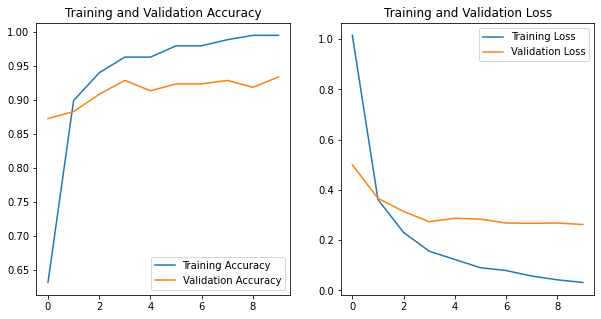

In [21]:
# plot training accuracy and loss
plot_training(history)

[INFO] evaluating network...
7/7 [==============================] - 0s 42ms/step - loss: 0.2623 - accuracy: 0.9337
[INFO] Test Accuracy: 93.37%
[INFO] Test Loss: 0.2623

                     precision    recall  f1-score   support

     batik priangan       0.88      0.85      0.86        33
  batik megamendung       0.94      0.97      0.96        34
batik pring sedapur       0.88      0.88      0.88        33
       batik kawung       0.98      0.96      0.97        56
       batik parang       0.95      0.97      0.96        40

           accuracy                           0.93       196
          macro avg       0.93      0.93      0.93       196
       weighted avg       0.93      0.93      0.93       196

[[28  2  3  0  0]
 [ 0 33  1  0  0]
 [ 3  0 29  1  0]
 [ 0  0  0 54  2]
 [ 1  0  0  0 39]]

Normalized confusion matrix


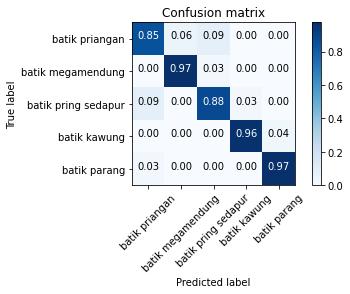

In [22]:
# test the model
testing()

Saving download (1).jpg to download (1).jpg
Saving download (2).jpg to download (2).jpg
Saving download (3).jpg to download (3).jpg
batik megamendung 0.9999999
batik megamendung 0.9999999
batik megamendung 0.99999523


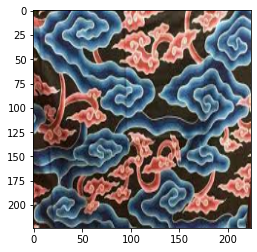

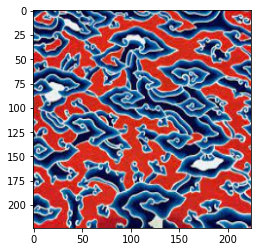

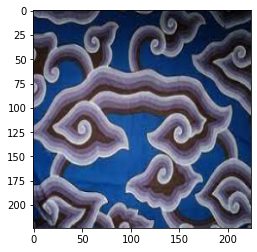

In [19]:
# predict megamendung pattern
predict(show=True)

Saving images (91).jpg to images (91).jpg
Saving images (92).jpg to images (92).jpg
Saving images (93).jpg to images (93).jpg
batik kawung 1.0
batik kawung 0.9999949
batik kawung 0.99999917


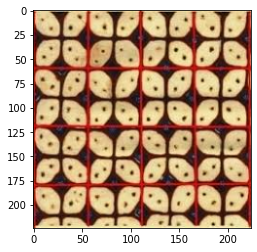

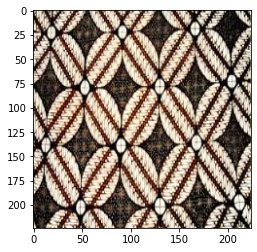

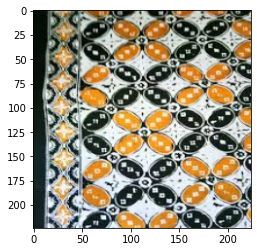

In [20]:
# predict kawung pattern
predict(show=True)

Saving images (21).jpg to images (21).jpg
Saving images (23).jpg to images (23).jpg
Saving download (12).jpg to download (12).jpg
batik parang 0.99997544
batik parang 0.9999999
batik parang 0.9999987


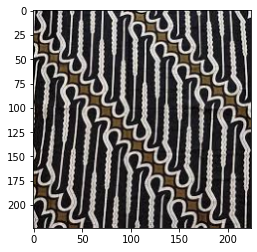

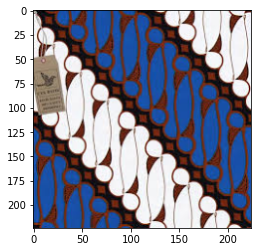

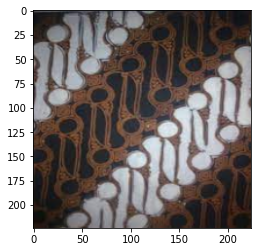

In [21]:
# predict parang pattern
predict(show=True)

Saving images - 2021-05-18T195709.393.jpg to images - 2021-05-18T195709.393.jpg
Saving images - 2021-05-18T195709.549.jpg to images - 2021-05-18T195709.549.jpg
Saving images - 2021-05-18T195709.867.jpg to images - 2021-05-18T195709.867.jpg
batik pring sedapur 0.99999917
batik pring sedapur 0.9999999
batik pring sedapur 0.9999906


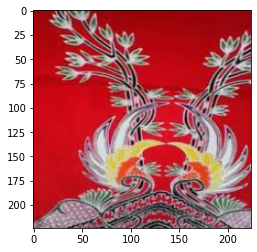

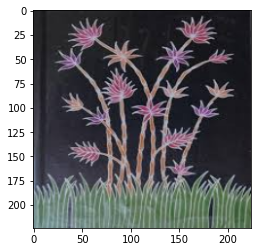

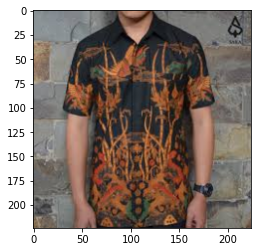

In [22]:
# predict pring sedapur pattern
predict(show=True)

Saving download (1).jpg to download (1).jpg
Saving download (4).jpg to download (4).jpg
Saving images (64).jpg to images (64).jpg
batik priangan 0.9999918
batik priangan 0.9999479
batik priangan 0.99999964


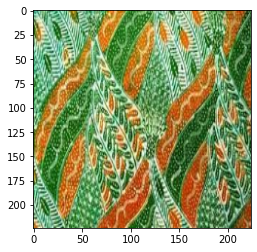

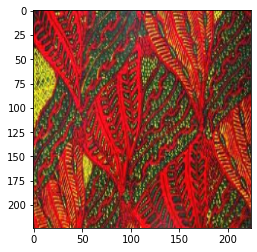

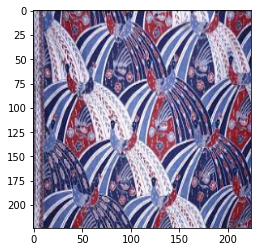

In [24]:
# predict priangan pattern
predict(show=True)